In [1]:
import numpy as np
import radis
from radis import calc_spectrum
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

from radis import Spectrum

In [ ]:
# Import necessary libraries and modules
import os
import numpy as np
import random
from Toolbox.Toolbox_Processing import *
from Toolbox.Toolbox_Reading import *
from Toolbox.Toolbox_Inversion import *
from Toolbox.Toolbox_Display import *

# Define the path to the spectra data
#path = "/home/luke/lukeflamingradis/EmFit_private/spectra/test_series"
base_path = "/home/luke/data/MATRIX_data/"
dataset = "Peat6"

os.makedirs('/home/luke/data/Model/results_param/'+dataset+'/', exist_ok=True)

P, T = getPT(dataset)

# Load chemical compound information from a pickle file
Compounds = getCompounds('/home/luke/lukeflamingradis/EmFit_private/EmissionsSpeciesInfo.pickle')

# List of compounds to be removed from the Compounds dictionary
remove = ['SiH', 'CaF', 'SiS', 'BeH', 'HF', 'NH', 'SiH2', 'AlF', 'SH', 'CH', 'AlH', 'TiH', 'CaH', 'LiF', 'MgH', 'ClO', 'CH3Br', 'H2S']

# Remove specified compounds from the Compounds dictionary
for r in remove:
    Compounds.pop(r)

regularisation_constant = 10**(-3)

ref_spec, obs_spec, full_ref_spec, Compounds = generateData(Compounds, base_path + dataset, 0, 273, 1.01325, dataset)

ref_spec, Compounds, Lasso_Evaluation, full_ref_spec = lasso_inversion(ref_spec, full_ref_spec, obs_spec, Compounds)

x_sol, sigma, C = temporally_regularised_inversion(ref_spec, obs_spec, regularisation_constant, dataset, list(Compounds.keys()))

(Ns, Nl), Nt = ref_spec.shape, obs_spec.shape[0]

from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

wv_obs = np.load('/home/luke/data/Model/results/'+ dataset + '/W.npy')
T_guess = np.linspace(273, 673, 200)
P_guess = np.linspace(0.9, 10, 200)
initial_params = np.concatenate([T_guess, P_guess])
# Define bounds for the parameters if needed
bounds = [(0, None)] * len(initial_params)  # Assuming non-negative values for simplicity

Full_Ref_Spec = []
Ref_Spec = []
Wv_selec = []
Obs_selec = []

for i, spc in enumerate(list(Compounds.keys())):

    print(spc)

    species_arr = x_sol[i * Nt:(i + 1) * Nt]
    ind = np.argmax(species_arr)
    obs_selection = obs_spec[ind]

    loc = generateSingleRef(Compounds[spc], spc, wv_obs, 273, 1.01)[1]

    # obs_selection = [element for start, end in loc for element in obs_selection[start:end + 1]]
    # wv_selection = [element for start, end in loc for element in wv_obs[start:end + 1]]
    
    Tmp1 = []
    Tmp2 = []

    for l in loc:
        start, end = l
        Tmp1.append(wv_obs[start:end + 1])
        Tmp2.append(obs_selection[start:end + 1])

    Wv_selec.append(Tmp1)
    Obs_selec.append(Tmp2)


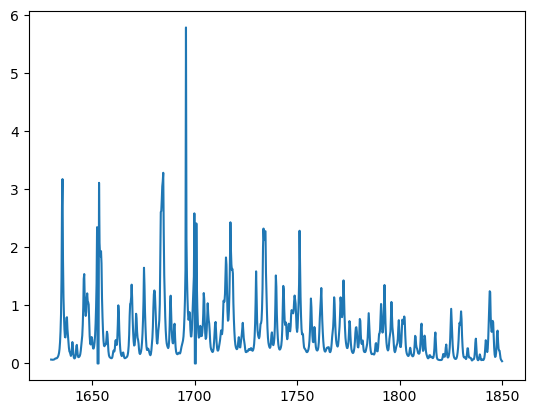

In [14]:
from radis import Spectrum, SpectrumFactory
from radis.test.utils import getValidationCase, setup_test_line_databases
from radis.tools.fitting import Tvib12Tvib3Trot_NonLTEModel

plt.plot(Wv_selec[0][0], Obs_selec[0][0])

In [28]:
s = Spectrum.from_array(Wv_selec[3][0], Obs_selec[3][0], 'absorbance',
                           wunit='cm-1', unit='') # adimensioned

/home/luke/.mambaforge/lib/python3.10/site-packages/radis/spectrum/spectrum.py:4400: UserWarning: Wavespace is not evenly spaced (0.010%) for absorbance. This may create problems if later convolving with slit function (`s.apply_slit()`). You can use `s.resample_even()`
  warn(


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Avant Garde, sans-serif


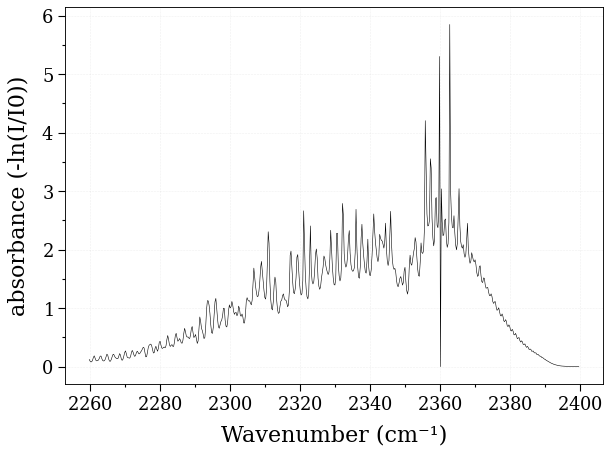

In [29]:
s.plot()

In [34]:
sf = SpectrumFactory(
                     wavenum_min=min(Wv_selec[3][0]),
                     wavenum_max=max(Wv_selec[3][0]),
                     molecule = 'CO2',
                     mole_fraction=10e-6,
                     path_length=500,  # cm
                     isotope = 1,
                     export_lines=True,    # required for LineSurvey!
                     db_use_cached=True)

sf.fetch_databank('hitran', 'range')

s_best, best = sf.fit_spectrum(
    s.take("absorbance"),
    model=Tvib12Tvib3Trot_NonLTEModel,
    fit_parameters={
        "T12": 517,
        "T3": 2641,
        "Trot": 491,
    },
    bounds={"T12": [300, 2000], "T3": [300, 5000], "Trot": [300, 2000]},
    fixed_parameters={"vib_distribution": "treanor"},
    plot=True,
    solver_options={
        "method": "TNC",
        "maxiter": 80,  # 👈 increase to let the fit converge
    },
)

Using cache file: /home/luke/.astropy/cache/astroquery/Hitran/tempfile_CO2_1_2259.89_2399.71.h5
Calculating Non-Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 491 K
   Trot                 491 K
   Tvib                 517,517,2641 K
   isotope              1
   mole_fraction        1e-05
   molecule             CO2
   path_length          500 cm
   pressure_mbar        1013.25 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution     treanor
   wavenum_max          2399.7120 cm-1
   wavenum_min          2259.8850 cm-1
Computation Parameters
----------------------------------------
   Tref                 296 K
   add_at_used          
   broadening_method    voigt
   cutoff               0 cm-1/(#.cm-2)
   dbformat             hitran
   dbpath               fetched from hitran
   diluent              air
   folding_thresh       1e-06
   include_neighbouring_lines  Tru

/home/luke/.mambaforge/lib/python3.10/site-packages/radis/misc/warning.py:369: HighTemperatureWarning: HITRAN is valid for low temperatures (typically < 700 K). For higher temperatures you may need HITEMP or CDSD. See the 'databank=' parameter
  warnings.warn(WarningType(message))


Fetching Evib & Erot. If using this code several times you should consider updating the database directly. See functions in factory.py 


KeyError: 'iso'

In [ ]:
from radis import fetch_hitran
df = fetch_hitran("CO")
print(df.columns)
print(df['Tdpair'])
print(df['wav'])

In [ ]:
from radis.lbl import broadening

In [ ]:
broadening.voigt_broadening_HWHM(df, 1, 10**(-6), 270, 270)

In [ ]:
def convolve_with_peaks(x, y, sigma):
    delta_functions = np.eye(len(x))
    gaussian_kernel = gaussian_filter1d(delta_functions, sigma, mode='constant', cval=0.0, axis=0)
    convolved_y = np.dot(gaussian_kernel, y)
    
    return convolved_y

def gaussian(x, mu, sigma):
    return np.exp(-((x - mu) / sigma) ** 2 / 2) / (sigma * np.sqrt(2 * np.pi))


Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 693 K
   Trot                 693 K
   Tvib                 693 K
   isotope              1,2,3
   mole_fraction        1e-06
   molecule             CO2
   overpopulation       None
   path_length          500 cm
   pressure_mbar        20013.25 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution     boltzmann
   wavenum_max          2400.0000 cm-1
   wavenum_min          2200.0000 cm-1
Computation Parameters
----------------------------------------
   Tref                 296 K
   add_at_used          
   broadening_method    voigt
   cutoff               1e-27 cm-1/(#.cm-2)
   dbformat             hitran
   dbpath               /home/luke/.radisdb/hitran/CO2.hdf5
   diluent              air
   folding_thresh       1e-06
   include_neighbouring_lines  True
   memory_mapping_engine  auto
   neighbour_lines  

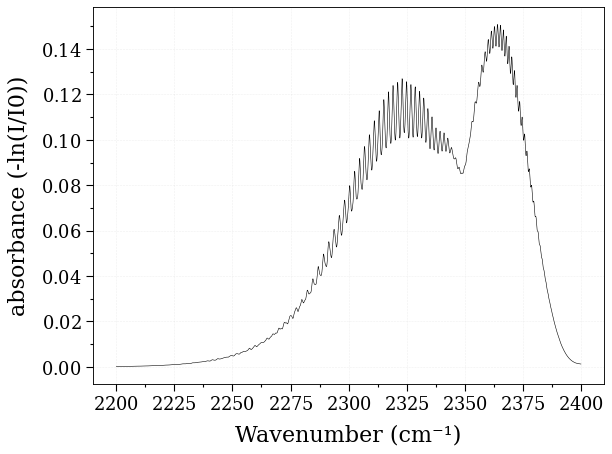

In [5]:
s = calc_spectrum(2200, 2400,         # cm-1
                  molecule='CO2',
                  isotope='1,2,3',
                  pressure=20.01325,   # bar
                  Tgas=693,           # K
                  mole_fraction=10**(-6),
                  path_length=500,      # cm
                  databank='hitran',  # or 'hitemp', 'geisa', 'exomol'
                  )
#s.apply_slit(400.241, 'nm')       # simulate an experimental slit
s.plot('absorbance')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Avant Garde, sans-serif


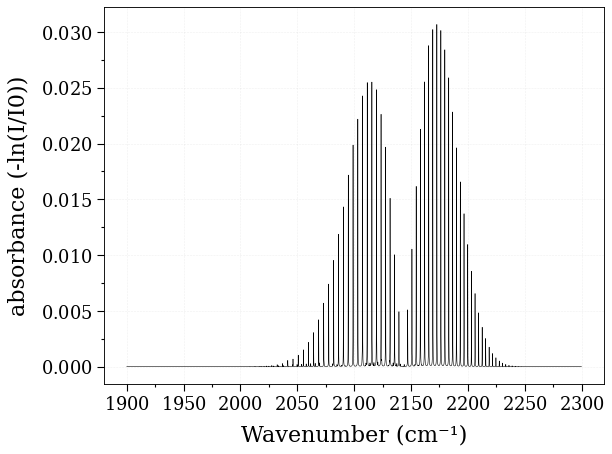

In [3]:
s.plot('absorbance')

In [ ]:
def generateSingleRef()

In [ ]:
def convolve_with_peaks(x, y, sigma):
    # Create a Gaussian-shaped kernel
    kernel_size = int(4 * sigma + 1)  # Adjust the size of the kernel based on the sigma
    kernel = np.exp(-(np.arange(kernel_size) - kernel_size // 2)**2 / (2 * sigma**2))
    kernel /= kernel.sum()

    # Convolve the data with the Gaussian kernel
    convolved_y = np.convolve(y, kernel, mode='same')

    return convolved_y

In [ ]:
w, A = s.get('absorbance', wunit='cm-1')
A = np.nan_to_num(A, nan=0)
plt.plot(w,A); plt.show()

broadened_A = convolve_with_peaks(w, A, 0.1)
broadened_A = np.nan_to_num(broadened_A, nan=0)

plt.plot(w, broadened_A)
plt.show()

w, A = s.get('absorbance', wunit='cm-1')
A = np.nan_to_num(A, nan=0)

broadened_A2 = convolve_with_peaks(w, A, 10000)
broadened_A2 = np.nan_to_num(broadened_A, nan=0)

plt.plot(w, broadened_A2)
plt.plot()

print(max(broadened_A), max(broadened_A2))

In [ ]:
from scipy.signal import convolve

# Define a Gaussian kernel
kernel_size = 50
sigma = 100
kernel = np.exp(-(np.arange(kernel_size) - kernel_size // 2)**2 / (2 * sigma**2))
kernel /= kernel.sum()  # Normalize the kernel

# Convolve the data with the kernel
smoothed_y = convolve(A, kernel, mode='same')
plt.plot(w, smoothed_y)

In [ ]:
sigma = 0.8
norm_constant = 1 / (np.sqrt(2 * np.pi) * sigma)

broadened_A = convolve(A, norm_constant* np.exp(-(w - np.median(w))**2 / (2 * sigma**2)), mode='same')
plt.plot(w, broadened_A)

In [ ]:
y_broadened = gaussian_filter1d(A, sigma=0.8)
y_broadened2 = gaussian_filter1d(A, sigma=0.8*6)


print(sigma, max(y_broadened2)/max(y_broadened), max(y_broadened))
plt.plot(w,A)
plt.plot(w,y_broadened2)
#plt.plot(w,y_broadened)

In [ ]:
def gaussian_broadening(x, x0, sigma):
    """
    Calculate the Gaussian broadening of a peak.

    Parameters:
    - x: array of x values
    - x0: center of the peak
    - sigma: standard deviation (width) of the peak

    Returns:
    - Gaussian broadening function values corresponding to each x value
    """
    return np.exp(-0.5 * ((x - x0) / sigma)**2)

def broaden_spectrum(x, y, broadening_function):
    """
    Broaden a spectrum using a given broadening function.

    Parameters:
    - x: array of x values (original data)
    - y: array of y values (original data)
    - broadening_function: function used for broadening

    Returns:
    - Broadened spectrum (convolution of original spectrum and broadening function)
    """
    broadened_y = convolve(y, broadening_function, mode='same') / sum(broadening_function)
    return broadened_y

def weighted_average_center(x, y):
    """
    Calculate the weighted average center of a spectrum.

    Parameters:
    - x: array of x values (original data)
    - y: array of y values (original data)

    Returns:
    - Weighted average center
    """
    total_intensity = np.sum(y)
    weighted_average = np.sum(x * y) / total_intensity
    return weighted_average


selected_centre = weighted_average_center(w,A)
broadening_function = gaussian_broadening(w, x0=selected_centre, sigma=0.8)
broadened_spectrum = broaden_spectrum(w, A, broadening_function)

In [ ]:
plt.plot(w, broadened_spectrum)
#plt.plot(w,A)

In [ ]:
def broaden_continuous_spectrum(x, y, broadening_function):
    """
    Broaden a continuous absorption spectrum using a given broadening function.

    Parameters:
    - x: array of x values (original data)
    - y: array of y values (original data)
    - broadening_function: function used for broadening

    Returns:
    - Broadened spectrum (convolution of original spectrum and broadening function for each peak)
    """
    # Ensure broadening function is normalized
    broadening_function /= np.sum(broadening_function)

    # Convolve the entire spectrum with the broadening function
    broadened_spectrum = convolve(y, broadening_function, mode='same')

    return broadened_spectrum

In [ ]:
broadening_function = gaussian_broadening(w, x0=0, sigma=1)  # Adjust sigma as needed
broadened_spectrum = broaden_continuous_spectrum(w, A, broadening_function)

plt.plot(w, broadened_spectrum)
